In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from wrangle import epl_aq_all
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import regex as re

from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

In [2]:
from preprocessing import preprocessing_script

In [3]:
import sklearn.metrics as m
from sklearn.model_selection import cross_val_score

# Project Goals
1. Create a regression of point differential in predicting future points
2. Analyze the importance of draws in pythagorean expectations predictions
3. Predict by placement (classification) especially on relegation side??

# Wrangle Data
Three functions acquiring and prepping data are all available in wrangle.py file.
- 1. `epl_year_aq`: pulls in data frame from season
- 2. `strip_team_name`: takes in season csv and splits and cleans team_name_column 
- 3. `epl_aq_all`: creates df of all seasons of epl
- 4. `rename columns`: renamess columns explicitly
- 5. `make_number_of_seasons`: makes a column for number of seasons

In [4]:
df = epl_aq_all()

In [5]:
print(df.shape)
df.info()

(360, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   team_name          360 non-null    object
 1   games_played       360 non-null    int64 
 2   wins               360 non-null    int64 
 3   draws              360 non-null    int64 
 4   losses             360 non-null    int64 
 5   goals_for          360 non-null    int64 
 6   goals_against      360 non-null    int64 
 7   goal_differential  360 non-null    int64 
 8   points             360 non-null    int64 
 9   year               360 non-null    int64 
 10  place              360 non-null    int64 
 11  seasons_in_epl     360 non-null    int64 
dtypes: int64(11), object(1)
memory usage: 33.9+ KB


In [6]:
df = preprocessing_script(df)

In [7]:
df

,team_name,games_played,wins,draws,losses,goals_for,goals_against,goal_differential,points,year,place,seasons_in_epl,finish,next_season_points,goal_percentage,win_rate,surpluss_goals,points_rate,goals_per_loss
0,AFC Bournemouth,38,11,9,18,45,67,-22,42,2015,16,5,relegation_battle,46.0,0.401786,0.611111,-33,1.111111,2.500000
1,AFC Bournemouth,38,12,10,16,55,67,-12,46,2016,9,5,mid_table,44.0,0.450820,0.750000,-24,1.375000,3.437500
2,AFC Bournemouth,38,11,11,16,45,61,-16,44,2017,12,5,mid_table,45.0,0.424528,0.687500,-27,1.375000,2.812500
3,AFC Bournemouth,38,13,6,19,56,70,-14,45,2018,14,5,mid_table,34.0,0.444444,0.684211,-27,1.000000,2.947368
4,AFC Bournemouth,38,9,7,22,40,65,-25,34,2019,18,5,relegation,NaN,0.380952,0.409091,-34,0.727273,1.818182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,Wolverhampton Wanderers,38,9,11,18,32,56,-24,38,2009,15,6,relegation_battle,40.0,0.363636,0.500000,-33,1.111111,1.777778
356,Wolverhampton Wanderers,38,11,7,20,46,66,-20,40,2010,17,6,relegation_battle,25.0,0.410714,0.550000,-31,0.900000,2.300000
357,Wolverhampton Wanderers,38,5,10,23,40,82,-42,25,2011,20,6,relegation,57.0,0.327869,0.217391,-47,0.652174,1.739130
358,Wolverhampton Wanderers,38,16,9,13,47,46,1,57,2018,7,6,europa_league,59.0,0.505376,1.230769,-15,1.923077,3.615385


In [8]:
df['next_year'] = df.year.shift(-1)

In [9]:
(df[['points', 'goal_differential', 'next_season_points', 
     'wins', 'goals_for', 'goals_against', 'place', 'losses', 
     'goal_percentage', 'win_rate', 'surpluss_goals', 'points_rate',
    'goals_per_loss', 'seasons_in_epl']]
     .dropna().corr().next_season_points)

points                0.786692
goal_differential     0.808888
next_season_points    1.000000
wins                  0.762256
goals_for             0.750810
goals_against        -0.707387
place                -0.728315
losses               -0.775132
goal_percentage       0.816199
win_rate              0.559267
surpluss_goals        0.806492
points_rate           0.558556
goals_per_loss        0.580155
seasons_in_epl        0.638168
Name: next_season_points, dtype: float64

#### Overview of the dataframe

In [10]:
print(df.shape)
print(df.info())
df.head(2)

(360, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   team_name           360 non-null    object 
 1   games_played        360 non-null    int64  
 2   wins                360 non-null    int64  
 3   draws               360 non-null    int64  
 4   losses              360 non-null    int64  
 5   goals_for           360 non-null    int64  
 6   goals_against       360 non-null    int64  
 7   goal_differential   360 non-null    int64  
 8   points              360 non-null    int64  
 9   year                360 non-null    int64  
 10  place               360 non-null    int64  
 11  seasons_in_epl      360 non-null    int64  
 12  finish              360 non-null    object 
 13  next_season_points  320 non-null    float64
 14  goal_percentage     360 non-null    float64
 15  win_rate            360 non-null    float64
 16

,team_name,games_played,wins,draws,losses,goals_for,goals_against,goal_differential,points,year,place,seasons_in_epl,finish,next_season_points,goal_percentage,win_rate,surpluss_goals,points_rate,goals_per_loss,next_year
0,AFC Bournemouth,38,11,9,18,45,67,-22,42,2015,16,5,relegation_battle,46.0,0.401786,0.611111,-33,1.111111,2.5000,2016.0
1,AFC Bournemouth,38,12,10,16,55,67,-12,46,2016,9,5,mid_table,44.0,0.450820,0.750000,-24,1.375000,3.4375,2017.0


In [11]:
df.describe()

,games_played,wins,draws,losses,goals_for,goals_against,goal_differential,points,year,place,seasons_in_epl,next_season_points,goal_percentage,win_rate,surpluss_goals,points_rate,goals_per_loss,next_year
count,360.0,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,320.000000,360.000000,360.000000,360.000000,360.000000,360.000000,359.000000
mean,38.0,14.244444,9.511111,14.244444,50.811111,50.811111,0.000000,52.219444,2010.500000,10.500000,12.511111,53.146875,0.496806,inf,-14.244444,inf,inf,2010.487465
std,0.0,6.033446,2.842160,5.590105,15.665653,13.099699,26.046348,17.246667,5.195348,5.774307,5.161988,17.326307,0.123009,NaN,20.415222,NaN,NaN,5.197145
min,38.0,1.000000,2.000000,0.000000,20.000000,15.000000,-69.000000,11.000000,2002.000000,1.000000,1.000000,15.000000,0.183486,0.034483,-70.000000,0.310345,0.689655,2002.000000
25%,38.0,10.000000,7.000000,10.000000,40.000000,41.000000,-19.000000,40.000000,2006.000000,5.750000,8.000000,41.000000,0.407407,0.554167,-28.250000,1.111111,2.280952,2006.000000
50%,38.0,13.000000,9.000000,15.000000,47.000000,51.000000,-7.000000,48.000000,2010.500000,10.500000,13.000000,49.000000,0.465231,0.812500,-19.000000,1.533333,3.000000,2010.000000
75%,38.0,18.000000,11.000000,18.000000,59.000000,59.000000,15.250000,63.000000,2015.000000,15.250000,18.000000,64.000000,0.582647,1.727273,-1.000000,2.800000,5.694231,2015.000000
max,38.0,32.000000,17.000000,29.000000,106.000000,89.000000,79.000000,100.000000,2019.000000,20.000000,18.000000,100.000000,0.827586,inf,47.000000,inf,inf,2019.000000


# Explore

## Are goals per game increasing over time?

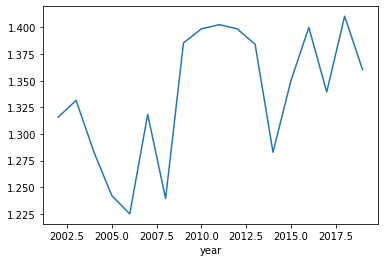

In [12]:
(df.groupby('year').goals_for.mean()/38).plot()

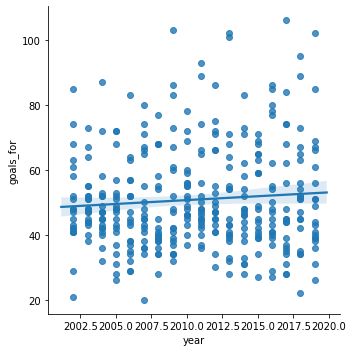

In [13]:
sns.lmplot(x='year', y='goals_for', data=df)

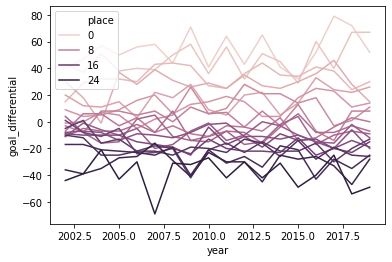

In [14]:
sns.lineplot(x ='year', y ='goal_differential', data=df, hue='place')

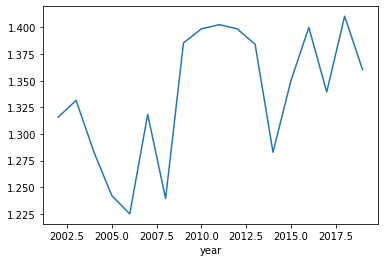

In [15]:
(df.groupby('year').goals_against.mean()/38).plot()

### Team Results

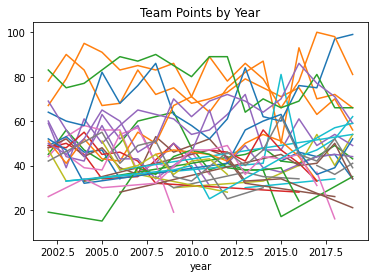

In [16]:
df.set_index('year').groupby('team_name').points.plot()
plt.title('Team Points by Year')
plt.show()

**Takeaways** At the top of the viz, you can see that there are a couple teams that have stayed at the top of the table, but as you get further towards the middle, the data becomes a lot more muddled

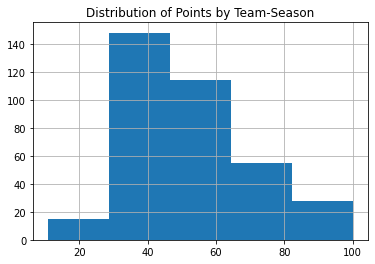

In [17]:
df.points.hist(bins=5)
plt.title("Distribution of Points by Team-Season")
plt.show()

**Takeaways** Looks like a poisson distribution.

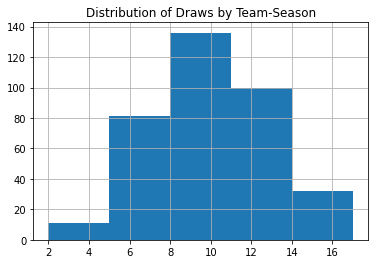

In [18]:
df.draws.hist(bins=5)
plt.title("Distribution of Draws by Team-Season")
plt.show()

**Takeaways** Normal distribution around 9-10 draws per season

In [19]:
df.draws.describe()

count    360.000000
mean       9.511111
std        2.842160
min        2.000000
25%        7.000000
50%        9.000000
75%       11.000000
max       17.000000
Name: draws, dtype: float64

Average number of draws per year is 9.5

### Exploring Draws a little more closely

Text(0.5, 1.0, 'Is There a Pattern for Draws by Table Place?')

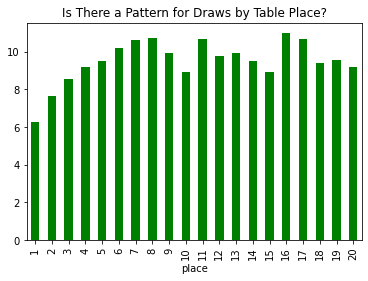

In [20]:
df.groupby('place').draws.mean().plot.bar(color='green')
plt.title('Is There a Pattern for Draws by Table Place?')

**Takeaways** Number of draws tend to be higher at the middle of the table

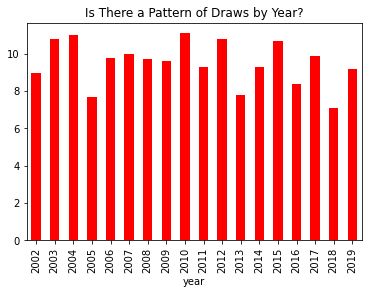

In [21]:
df.groupby('year').draws.mean().plot.bar(color='red')
plt.title('Is There a Pattern of Draws by Year?')
plt.show()

**Takeaways** Not really, there is a pretty significant difference between certain years, but no noticeable trends
**Furtherwork** Some hypothesis testing and statistical analysis

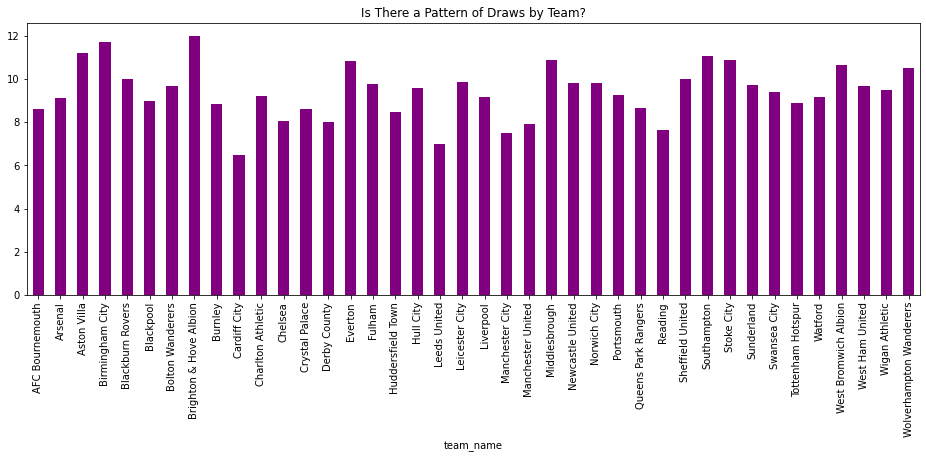

In [22]:
plt.figure(figsize=(16,5))
df.groupby('team_name').draws.mean().plot.bar(color='purple')
plt.title('Is There a Pattern of Draws by Team?')
plt.show()

**Takeaways** Likely, but not immediately evident.

Text(0.5, 1.0, 'Because of Relegation, How Many Seasons Has Each Team Played?')

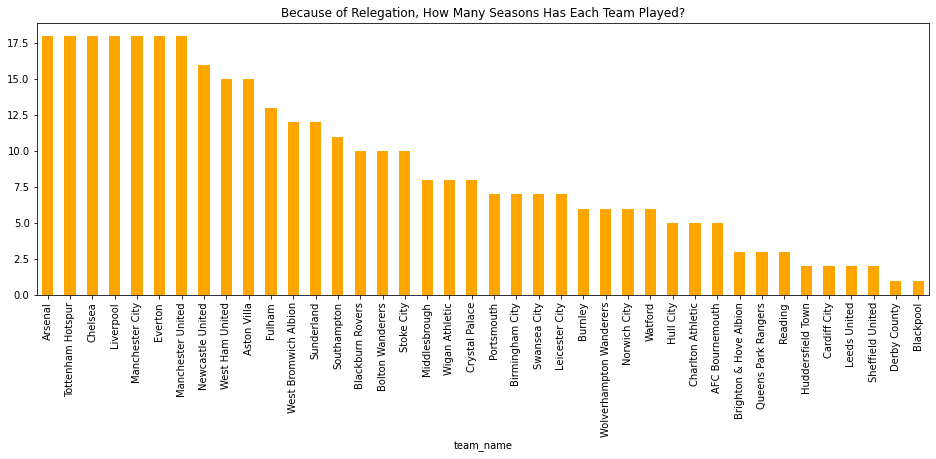

In [23]:
plt.figure(figsize=(16,5))
df.groupby('team_name').draws.count().sort_values(ascending=False).plot.bar(color='orange')
plt.title('Because of Relegation, How Many Seasons Has Each Team Played?')

### Just for fun , lets look at scatter plots of number of seasons and average number of points and draws!

Text(0.5, 1.0, 'What is the Relationship between No of Seasons in EPL and Avg No of Draws')

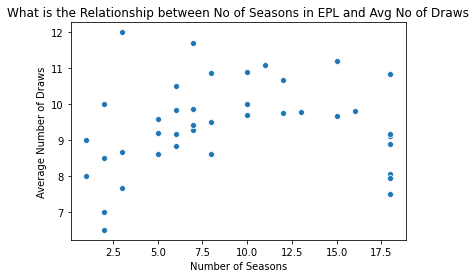

In [24]:
df_temp = df.groupby('team_name').draws.agg(['count', 'mean'])
sns.scatterplot(x='count', y='mean', data=df_temp)
plt.xlabel('Number of Seasons')
plt.ylabel('Average Number of Draws')
plt.title('What is the Relationship between No of Seasons in EPL and Avg No of Draws')

Text(0.5, 1.0, 'What is the Relationship between No of Seasons in EPL and Avg Points')

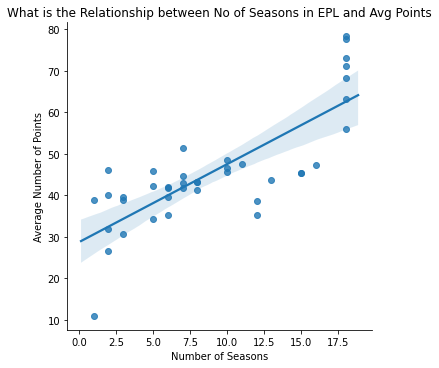

In [25]:
df_temp = df.groupby('team_name').points.agg(['count', 'mean'])
sns.lmplot(x='count', y='mean', data=df_temp)
plt.xlabel('Number of Seasons')
plt.ylabel('Average Number of Points')
plt.title('What is the Relationship between No of Seasons in EPL and Avg Points')

**Takeaways:** Seems to be a pretty clear linear relationship between number of seasons in the Premier League and the Average number of Points

Text(0.5, 1.0, 'What is the relationship between points and goal differential')

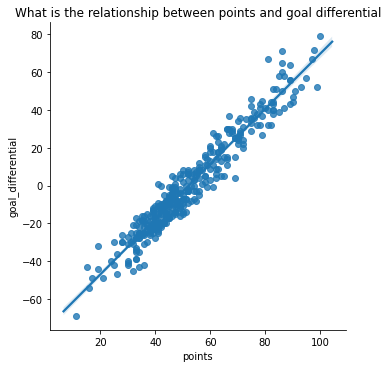

In [26]:
sns.lmplot(x='points', y = 'goal_differential', data = df)
plt.title('What is the relationship between points and goal differential')

Text(0.5, 1.0, 'What is the relationship between points and place')

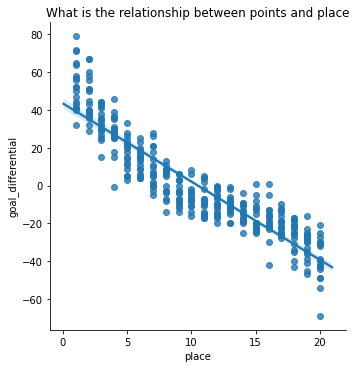

In [27]:
sns.lmplot(x='place', y = 'goal_differential', data = df)
plt.title('What is the relationship between points and place')

### Is it better to win or avoid a loss?

Text(0, 0.5, 'Absolute value of correlation')

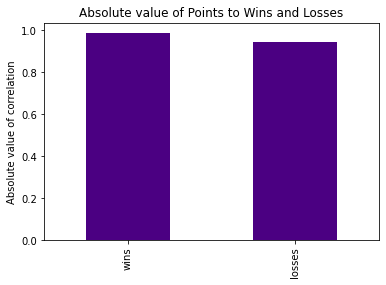

In [28]:
df[['wins', 'losses', 'points']].corr().points[0:2].abs().plot.bar(color='indigo')
plt.title("Absolute value of Points to Wins and Losses")
plt.ylabel('Absolute value of correlation')

**Takeaways:** Although there is a high absolute correlation to both.  It appears that winning is more important than avoiding losses.

Text(0, 0.5, 'Absolute value of correlation')

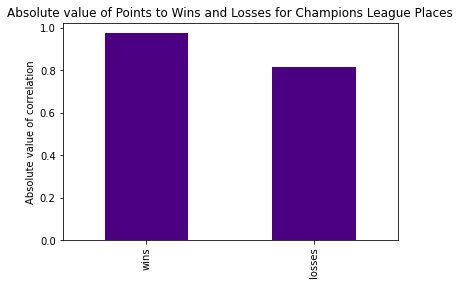

In [29]:
df[df.place <= 4][['wins', 'losses', 'points']].corr().points[0:2].abs().plot.bar(color='indigo')
plt.title("Absolute value of Points to Wins and Losses for Champions League Places")
plt.ylabel('Absolute value of correlation')

Text(0, 0.5, 'Absolute value of correlation')

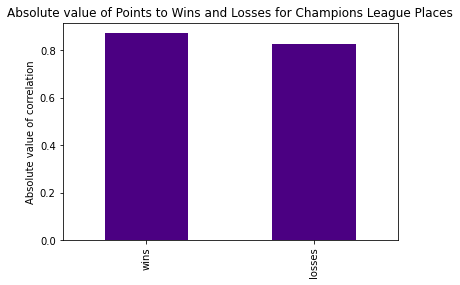

In [30]:
df[df.place >= 18][['wins', 'losses', 'points']].corr().points[0:2].abs().plot.bar(color='indigo')
plt.title("Absolute value of Points to Wins and Losses for Champions League Places")
plt.ylabel('Absolute value of correlation')

# Modeling

In [31]:
df.head()

,team_name,games_played,wins,draws,losses,goals_for,goals_against,goal_differential,points,year,place,seasons_in_epl,finish,next_season_points,goal_percentage,win_rate,surpluss_goals,points_rate,goals_per_loss,next_year
0,AFC Bournemouth,38,11,9,18,45,67,-22,42,2015,16,5,relegation_battle,46.0,0.401786,0.611111,-33,1.111111,2.500000,2016.0
1,AFC Bournemouth,38,12,10,16,55,67,-12,46,2016,9,5,mid_table,44.0,0.450820,0.750000,-24,1.375000,3.437500,2017.0
2,AFC Bournemouth,38,11,11,16,45,61,-16,44,2017,12,5,mid_table,45.0,0.424528,0.687500,-27,1.375000,2.812500,2018.0
3,AFC Bournemouth,38,13,6,19,56,70,-14,45,2018,14,5,mid_table,34.0,0.444444,0.684211,-27,1.000000,2.947368,2019.0
4,AFC Bournemouth,38,9,7,22,40,65,-25,34,2019,18,5,relegation,NaN,0.380952,0.409091,-34,0.727273,1.818182,2002.0


In [32]:



df_pred = df[(df.year - (df.next_year - 1)) == 0]

In [33]:
print(df_pred.shape)
df_pred.info()

(289, 20)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 289 entries, 0 to 358
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   team_name           289 non-null    object 
 1   games_played        289 non-null    int64  
 2   wins                289 non-null    int64  
 3   draws               289 non-null    int64  
 4   losses              289 non-null    int64  
 5   goals_for           289 non-null    int64  
 6   goals_against       289 non-null    int64  
 7   goal_differential   289 non-null    int64  
 8   points              289 non-null    int64  
 9   year                289 non-null    int64  
 10  place               289 non-null    int64  
 11  seasons_in_epl      289 non-null    int64  
 12  finish              289 non-null    object 
 13  next_season_points  289 non-null    float64
 14  goal_percentage     289 non-null    float64
 15  win_rate            289 non-null    float64
 16

In [34]:
predictions = pd.DataFrame({
    'yhat': df_pred['next_season_points']
})

In [35]:
lm = LinearRegression()

In [36]:
X = df_pred[['points']]
y = df_pred[['next_season_points']]

In [37]:
lm.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [38]:
predictions['pred_points'] = lm.predict(y)

In [39]:
predictions

,yhat,pred_points
0,46.0,46.072398
1,44.0,44.349299
2,45.0,45.210848
3,34.0,35.733808
5,90.0,83.980559
...,...,...
351,43.0,43.487750
352,36.0,37.456906
355,40.0,40.903103
356,25.0,27.979866


In [40]:
lm.score(X, y)

0.610911455020295

In [43]:
features_for_modeling = df_pred.drop(columns=['team_name', 'games_played', 'year', 'next_season_points', 'finish', 'win_rate', 'points_rate', 'goals_per_loss', 'next_year']).columns

In [44]:
features_for_modeling

Index(['wins', 'draws', 'losses', 'goals_for', 'goals_against',
       'goal_differential', 'points', 'place', 'seasons_in_epl',
       'goal_percentage', 'surpluss_goals'],
      dtype='object')

In [45]:
for i in features_for_modeling:
    X = df_pred[[i]]
    y = df_pred[['next_season_points']]
    lm.fit(X, y)
    predictions[f'pred_{i}'] = lm.predict(X)

In [46]:
predictions

,yhat,pred_points,pred_wins,pred_draws,pred_losses,pred_goals_for,pred_goals_against,pred_goal_differential,pred_place,pred_seasons_in_epl,pred_goal_percentage,pred_surpluss_goals
0,46.0,42.626201,44.259742,55.245444,41.181354,47.648017,33.995594,38.545292,36.887543,35.336762,39.452364,37.448435
1,44.0,46.072398,46.584827,54.284333,46.554845,56.077037,33.995594,44.402519,54.726644,35.336762,45.581741,44.173053
2,45.0,44.349299,44.259742,53.323222,46.554845,47.648017,40.464487,42.059628,47.081315,35.336762,42.295249,41.931514
3,34.0,45.210848,48.909911,58.128778,38.494608,56.919939,30.761147,43.231074,41.984429,35.336762,44.784820,41.931514
5,90.0,73.641969,72.160752,55.245444,73.422305,81.364094,60.949316,76.617273,72.565744,65.278309,72.891292,77.048962
...,...,...,...,...,...,...,...,...,...,...,...,...
351,43.0,42.626201,39.609574,49.478776,51.928337,43.433508,40.464487,39.131014,36.887543,42.246350,38.734084,39.689974
352,36.0,43.487750,44.259742,54.284333,43.868100,45.119312,39.386338,39.716737,39.435986,42.246350,39.709924,38.942795
355,40.0,39.180005,39.609574,53.323222,41.181354,36.690293,45.855232,37.373846,39.435986,37.639958,34.683591,37.448435
356,25.0,40.903103,44.259742,57.167667,35.807862,48.490919,35.073743,39.716737,34.339100,37.639958,40.568459,38.942795


In [47]:
prediction_features = predictions.drop(columns=('yhat')).columns

In [48]:
#determining rmse
score = []
for i in prediction_features:
    name = i
    rmse = ((predictions.yhat - predictions[i])**2).mean()**.5
    score.append(rmse)

In [49]:
pd.DataFrame({
    'feature': list(prediction_features),
    'rmse': score
})

,feature,rmse
0,pred_points,10.726305
1,pred_wins,11.281287
2,pred_draws,16.980857
3,pred_losses,11.028013
4,pred_goals_for,11.667521
5,pred_goals_against,12.109638
6,pred_goal_differential,10.190177
7,pred_place,11.825011
8,pred_seasons_in_epl,13.254679
9,pred_goal_percentage,10.028581


## Cross Validation

In [50]:
import sklearn.metrics as m
from sklearn.model_selection import cross_val_score

In [51]:
for i in features_for_modeling:
    X = df_pred[i]
    y = df_pred['points']
    print(f'{i} is {cross_val_score(lm, X, y, cv=2)}')

wins is [nan nan]
draws is [nan nan]
losses is [nan nan]
goals_for is [nan nan]
goals_against is [nan nan]
goal_differential is [nan nan]
points is [nan nan]
place is [nan nan]
seasons_in_epl is [nan nan]
goal_percentage is [nan nan]
surpluss_goals is [nan nan]


In [52]:
df_pred

,team_name,games_played,wins,draws,losses,goals_for,goals_against,goal_differential,points,year,place,seasons_in_epl,finish,next_season_points,goal_percentage,win_rate,surpluss_goals,points_rate,goals_per_loss,next_year
0,AFC Bournemouth,38,11,9,18,45,67,-22,42,2015,16,5,relegation_battle,46.0,0.401786,0.611111,-33,1.111111,2.500000,2016.0
1,AFC Bournemouth,38,12,10,16,55,67,-12,46,2016,9,5,mid_table,44.0,0.450820,0.750000,-24,1.375000,3.437500,2017.0
2,AFC Bournemouth,38,11,11,16,45,61,-16,44,2017,12,5,mid_table,45.0,0.424528,0.687500,-27,1.375000,2.812500,2018.0
3,AFC Bournemouth,38,13,6,19,56,70,-14,45,2018,14,5,mid_table,34.0,0.444444,0.684211,-27,1.000000,2.947368,2019.0
5,Arsenal,38,23,9,6,85,42,43,78,2002,2,18,champions_league,90.0,0.669291,3.833333,20,5.333333,14.166667,2003.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351,Wigan Athletic,38,9,15,14,40,61,-21,42,2010,16,8,relegation_battle,43.0,0.396040,0.642857,-30,1.714286,2.857143,2011.0
352,Wigan Athletic,38,11,10,17,42,62,-20,43,2011,15,8,relegation_battle,36.0,0.403846,0.647059,-31,1.235294,2.470588,2012.0
355,Wolverhampton Wanderers,38,9,11,18,32,56,-24,38,2009,15,6,relegation_battle,40.0,0.363636,0.500000,-33,1.111111,1.777778,2010.0
356,Wolverhampton Wanderers,38,11,7,20,46,66,-20,40,2010,17,6,relegation_battle,25.0,0.410714,0.550000,-31,0.900000,2.300000,2011.0


In [53]:
df_pred

,team_name,games_played,wins,draws,losses,goals_for,goals_against,goal_differential,points,year,place,seasons_in_epl,finish,next_season_points,goal_percentage,win_rate,surpluss_goals,points_rate,goals_per_loss,next_year
0,AFC Bournemouth,38,11,9,18,45,67,-22,42,2015,16,5,relegation_battle,46.0,0.401786,0.611111,-33,1.111111,2.500000,2016.0
1,AFC Bournemouth,38,12,10,16,55,67,-12,46,2016,9,5,mid_table,44.0,0.450820,0.750000,-24,1.375000,3.437500,2017.0
2,AFC Bournemouth,38,11,11,16,45,61,-16,44,2017,12,5,mid_table,45.0,0.424528,0.687500,-27,1.375000,2.812500,2018.0
3,AFC Bournemouth,38,13,6,19,56,70,-14,45,2018,14,5,mid_table,34.0,0.444444,0.684211,-27,1.000000,2.947368,2019.0
5,Arsenal,38,23,9,6,85,42,43,78,2002,2,18,champions_league,90.0,0.669291,3.833333,20,5.333333,14.166667,2003.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351,Wigan Athletic,38,9,15,14,40,61,-21,42,2010,16,8,relegation_battle,43.0,0.396040,0.642857,-30,1.714286,2.857143,2011.0
352,Wigan Athletic,38,11,10,17,42,62,-20,43,2011,15,8,relegation_battle,36.0,0.403846,0.647059,-31,1.235294,2.470588,2012.0
355,Wolverhampton Wanderers,38,9,11,18,32,56,-24,38,2009,15,6,relegation_battle,40.0,0.363636,0.500000,-33,1.111111,1.777778,2010.0
356,Wolverhampton Wanderers,38,11,7,20,46,66,-20,40,2010,17,6,relegation_battle,25.0,0.410714,0.550000,-31,0.900000,2.300000,2011.0


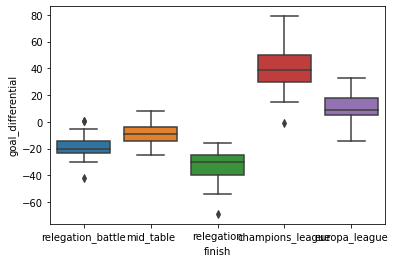

In [54]:
sns.boxplot(x='finish', y='goal_differential', data=df)